In [154]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, spectrogram, convolve
from scipy.io import wavfile
import sounddevice as sd
import subprocess

from utilities import *

In [89]:
# constellation_map = {
#     '00' : complex(1/np.sqrt(2), 1/np.sqrt(2)),
#     '01' : complex(-1/np.sqrt(2), 1/np.sqrt(2)),
#     '11' : complex(-1/np.sqrt(2), -1/np.sqrt(2)),
#     '10' : complex(1/np.sqrt(2), -1/np.sqrt(2)),
# }
constellation_map = {
    0: 1,
    1: -1,
}

QAM_symbols = np.array([*constellation_map.values()])
QAM_bits = np.array([*constellation_map.keys()])

In [125]:
N = 8192
L = 1024

source = np.random.choice(list(constellation_map.values()), (N-2)//2)
source
subcarrier_data = np.concatenate(([0], source, [0], np.conjugate(np.flip(source))))
x = np.fft.ifft(subcarrier_data).real
OFDM_symbol = np.concatenate((x[-L:], x))
OFDM_symbol /= np.max(np.abs(OFDM_symbol))

In [146]:
fs = 44100

t_chirp = np.linspace(0,1,fs)
chirp_standard = chirp(t_chirp, 1e3, 1, 10e3, method='linear')

pause = np.zeros(fs)

whitenoise = np.random.randn(fs)
whitenoise /= np.max(np.abs(whitenoise))

standard = np.concatenate([pause, chirp_standard, pause, whitenoise, pause])

OFDM_frame = np.tile(OFDM_symbol, 10)
signal = np.concatenate([standard, OFDM_frame])

In [198]:
plt.plot(signal)

In [134]:
write('OFDM/test_frame.wav', fs, signal)

In [152]:
subprocess.Popen(["afplay", "OFDM/test_frame.wav"])
received = sd.rec(len(signal), samplerate = fs, channels = 1, blocking = True).flatten()

In [176]:
def synchronise(received, chirp_standard):
    conv = convolve(received, np.flip(chirp_standard), mode='same')
    return np.argmax(np.abs(conv))

In [200]:
%matplotlib qt
plt.plot(received)
start = synchronise(received, chirp_standard)
for i in range(-2,13):
    plt.axvline(x=start+i*fs//2, c='r')
plt.show()

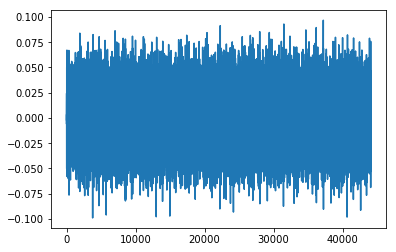

In [201]:
%matplotlib inline
received_frame = received[start+int(3.5*fs):start+int(4.5*fs)]
plt.plot(received_frame)

In [170]:
len(conv)

312660

In [171]:
len(received)

312660

In [172]:
np.argmax(conv)/fs

1.2227891156462585